In [ ]:
!pip install diffusers
from transformers.utils import move_cache
move_cache()

0it [00:00, ?it/s]

In [ ]:
!pip install diffusers flax jax jaxlib numpy

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/492M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

diffusion_flax_model.msgpack:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_flax_model.msgpack:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Saved image to generated_images/astronaut_rides_horse_0.png


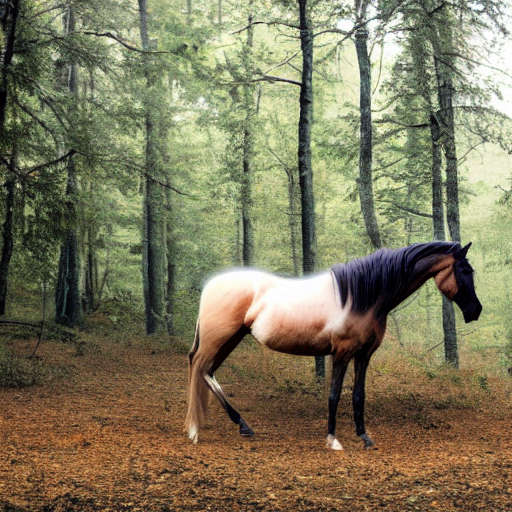

  adding: generated_images/ (stored 0%)
  adding: generated_images/astronaut_rides_horse_0.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import jax
import numpy as np
import os
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from diffusers import FlaxStableDiffusionPipeline
from IPython.display import display
from PIL import Image
from google.colab import files

# Load the pipeline and parameters
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision="flax", dtype=jax.numpy.bfloat16
)

# Define prompt and other parameters
prompt = "a horse in the forest"
prng_seed = jax.random.PRNGKey(0)
num_inference_steps = 50

# Determine the number of devices available
num_samples = jax.device_count()

# Prepare inputs for each device
prompt = num_samples * [prompt]
prompt_ids = pipeline.prepare_inputs(prompt)

# Shard inputs and RNG
params = replicate(params)
prng_seed = jax.random.split(prng_seed, num_samples)
prompt_ids = shard(prompt_ids)

# Generate images
images = pipeline(prompt_ids, params, prng_seed, num_inference_steps, jit=True).images
images = pipeline.numpy_to_pil(np.asarray(images.reshape((num_samples,) + images.shape[-3:])))

# Save images to the local directory
os.makedirs("generated_images", exist_ok=True)  # Create a folder to save images
for i, img in enumerate(images):
    image_path = f"generated_images/astronaut_rides_horse_{i}.png"
    img.save(image_path)
    print(f"Saved image to {image_path}")
    display(img)  # Display each generated image in Colab

# Optional: Zip and download all images
!zip -r generated_images.zip generated_images
files.download("generated_images.zip")
